In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from fastai.text import *
from sklearn.model_selection import train_test_split
import pickle
import sentencepiece as spm
import re
import pdb
import nltk
from sklearn.datasets import load_files
nltk.download('stopwords')
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pdshr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data = pd.read_csv("dataset.csv", skiprows=1, names=['label', 'headline'])
data.head()

,label,headline
0,business,"નીરવ મોદીના જેકેટમાં એવુ શું છે ખાસ, જેની કિંમ..."
1,business,નોટ નહી કરાવે ખોટઃશનિવાર અને રવિવાર બેન્કો ખુલ...
2,business,મોબાઇલ : ઇન્ટેક્સ કંપનીએ ઓછી કિંમતમાં લોન્ચ કર...
3,business,"એક જ નિર્ણયથી બદલાઈ ગઈ કિસ્મત, વર્ષભરમાં ફેમિલ..."
4,entertainment,"શ્રીદેવીના રાજકીય સન્માન સાથે અંતિમ સંસ્કાર, R..."


In [3]:
#converting categorical variables to numeric using label encoding
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
cat=['label']
for var in cat:
    le = preprocessing.LabelEncoder()
    data[var]=le.fit_transform(data[var].astype('str'))
data.dtypes
data.head()

,label,headline
0,0,"નીરવ મોદીના જેકેટમાં એવુ શું છે ખાસ, જેની કિંમ..."
1,0,નોટ નહી કરાવે ખોટઃશનિવાર અને રવિવાર બેન્કો ખુલ...
2,0,મોબાઇલ : ઇન્ટેક્સ કંપનીએ ઓછી કિંમતમાં લોન્ચ કર...
3,0,"એક જ નિર્ણયથી બદલાઈ ગઈ કિસ્મત, વર્ષભરમાં ફેમિલ..."
4,1,"શ્રીદેવીના રાજકીય સન્માન સાથે અંતિમ સંસ્કાર, R..."


<AxesSubplot:xlabel='label', ylabel='count'>

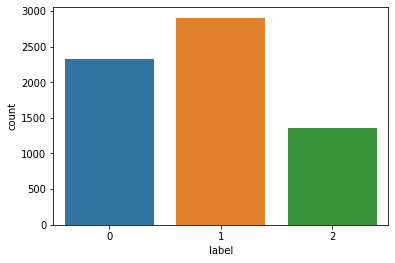

In [4]:
%matplotlib inline
import seaborn as sns
sns.countplot(x='label', data=data)

In [5]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

In [6]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
tfidfconverter = TfidfVectorizer(max_features=200, min_df=1, max_df=0.10)  
x = tfidfconverter.fit_transform(data['headline']).toarray()
X=data['headline']
y=data['label']

In [8]:
#Dividing the data into train and test set
from sklearn.model_selection import train_test_split  
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=200)

In [9]:
#Training and evaluating the text classification model
from sklearn.ensemble import RandomForestClassifier
text_classifier = RandomForestClassifier(n_estimators=200, random_state=0)  
text_classifier.fit(x_train, y_train)
predictions = text_classifier.predict(x_test)

In [10]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
 
print(confusion_matrix(y_test,predictions))  
print(classification_report(y_test,predictions))  
accuracy_rf = accuracy_score(y_test, predictions)*100

print('Random Forest Accuracy:', accuracy_rf)

[[306  97  55]
 [ 72 497  19]
 [ 84  40 147]]
              precision    recall  f1-score   support

           0       0.66      0.67      0.67       458
           1       0.78      0.85      0.81       588
           2       0.67      0.54      0.60       271

    accuracy                           0.72      1317
   macro avg       0.70      0.69      0.69      1317
weighted avg       0.72      0.72      0.72      1317

Random Forest Accuracy: 72.1336370539104


In [11]:
from sklearn.neighbors import  KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=10, metric='euclidean')
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)

In [12]:
print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred))  
accuracy_knn = accuracy_score(y_test, y_pred)*100
print('KNN Accuracy:', accuracy_knn)

[[292 135  31]
 [ 95 479  14]
 [ 73  69 129]]
              precision    recall  f1-score   support

           0       0.63      0.64      0.64       458
           1       0.70      0.81      0.75       588
           2       0.74      0.48      0.58       271

    accuracy                           0.68      1317
   macro avg       0.69      0.64      0.66      1317
weighted avg       0.69      0.68      0.68      1317

KNN Accuracy: 68.3371298405467


In [13]:
from sklearn.naive_bayes import  GaussianNB

gnb = GaussianNB()
gnb.fit(x_train, y_train)
y_pred = gnb.predict(x_test)

In [14]:
print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred))  
accuracy_gb = accuracy_score(y_test, y_pred)*100
print('GaussianNB Accuracy:',accuracy_gb)

[[213  37 208]
 [ 72 362 154]
 [ 35   3 233]]
              precision    recall  f1-score   support

           0       0.67      0.47      0.55       458
           1       0.90      0.62      0.73       588
           2       0.39      0.86      0.54       271

    accuracy                           0.61      1317
   macro avg       0.65      0.65      0.61      1317
weighted avg       0.71      0.61      0.63      1317

GaussianNB Accuracy: 61.35155656795747


In [15]:
from sklearn.tree import DecisionTreeClassifier
# Make a decision tree and train
tree = DecisionTreeClassifier()
tree.fit(x_train, y_train)
y_pred = tree.predict(x_test)

In [16]:
print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred))  
accuracy_dt = accuracy_score(y_test, y_pred)*100
print('Decision Tree:', accuracy_dt)

[[282 106  70]
 [118 433  37]
 [ 92  43 136]]
              precision    recall  f1-score   support

           0       0.57      0.62      0.59       458
           1       0.74      0.74      0.74       588
           2       0.56      0.50      0.53       271

    accuracy                           0.65      1317
   macro avg       0.63      0.62      0.62      1317
weighted avg       0.65      0.65      0.65      1317

Decision Tree: 64.61655277145026


In [17]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='linear')
svclassifier.fit(x_train, y_train)
y_pred = svclassifier.predict(x_test)

In [18]:
print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred))  
accuracy_sv = accuracy_score(y_test, y_pred)*100
print('Support vector machine :', accuracy_sv)

[[307  96  55]
 [ 76 500  12]
 [ 74  42 155]]
              precision    recall  f1-score   support

           0       0.67      0.67      0.67       458
           1       0.78      0.85      0.82       588
           2       0.70      0.57      0.63       271

    accuracy                           0.73      1317
   macro avg       0.72      0.70      0.71      1317
weighted avg       0.73      0.73      0.73      1317

Support vector machine : 73.04479878511769


In [19]:
from sklearn.linear_model import LogisticRegression
reg = LogisticRegression()   
reg.fit(x_train, y_train) 
y_pred = reg.predict(x_test) 

In [20]:
print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred))  
accuracy_lr = accuracy_score(y_test, y_pred)*100
print('Logistic Regression :', accuracy_lr)

[[307  93  58]
 [ 73 497  18]
 [ 74  39 158]]
              precision    recall  f1-score   support

           0       0.68      0.67      0.67       458
           1       0.79      0.85      0.82       588
           2       0.68      0.58      0.63       271

    accuracy                           0.73      1317
   macro avg       0.71      0.70      0.71      1317
weighted avg       0.73      0.73      0.73      1317

Logistic Regression : 73.04479878511769


In [21]:
from sklearn.model_selection import train_test_split  
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=200)
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
text_clf = Pipeline([('tfidf', TfidfVectorizer()),('clf', LinearSVC()),])
text_clf.fit(x_train, y_train) 
y_pred = text_clf.predict(x_test)

In [22]:
print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred))  
accuracy_pl = accuracy_score(y_test, y_pred)*100
print('Pipeline Accuracy:', accuracy_pl)

[[345  65  48]
 [ 43 533  12]
 [ 52  25 194]]
              precision    recall  f1-score   support

           0       0.78      0.75      0.77       458
           1       0.86      0.91      0.88       588
           2       0.76      0.72      0.74       271

    accuracy                           0.81      1317
   macro avg       0.80      0.79      0.80      1317
weighted avg       0.81      0.81      0.81      1317

Pipeline Accuracy: 81.39711465451785


In [23]:
Accuracy = [accuracy_rf,accuracy_knn,accuracy_gb,accuracy_dt,accuracy_sv,accuracy_lr, accuracy_pl]
col={'Accuracy': Accuracy}
models = ['Random forest','KNN','GaussianNB','Decision Tree','Support vector machine','Logistic Regression', 'Pipeline']
accuracy = pd.DataFrame(data=col, index=models)
accuracy

,Accuracy
Random forest,72.133637
KNN,68.337130
GaussianNB,61.351557
Decision Tree,64.616553
Support vector machine,73.044799
Logistic Regression,73.044799
Pipeline,81.397115


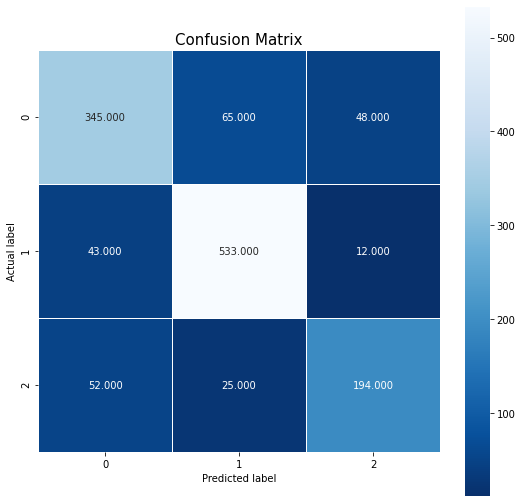

In [24]:
from sklearn import metrics
cm = metrics.confusion_matrix(y_test,y_pred)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Confusion Matrix'
plt.title(all_sample_title, size = 15);

In [25]:
s = ["PHOTOS: દેવ દિવાળી ઉજવવા બનારસ પહોંચ્યો અનિલ"]
pred = text_clf.predict(s)

In [26]:
pred

array([1])

In [27]:
import pickle
pickle.dump(text_clf,open('model.pkl','wb'))